In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
import tensorflow as tf
import malaya_speech
import malaya_speech.train
from malaya_speech.train.model import fastspeech2, lightspeech
import numpy as np

2022-06-13 14:33:18.751610: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
/home/ubuntu/tf-nvidia/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
_pad = 'pad'
_start = 'start'
_eos = 'eos'
_punctuation = "!'(),.:;? "
_special = '-'
_letters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'

MALAYA_SPEECH_SYMBOLS = (
    [_pad, _start, _eos] + list(_special) + list(_punctuation) + list(_letters)
)

In [4]:
input_ids = tf.placeholder(tf.int32, [None, None])
lens = tf.placeholder(tf.int32, [None, None])
mel_outputs = tf.placeholder(tf.float32, [None, None, 80])
mel_lengths = tf.placeholder(tf.int32, [None])
energies = tf.placeholder(tf.float32, [None, None])
energies_lengths = tf.placeholder(tf.int32, [None])
f0s = tf.placeholder(tf.float32, [None, None])
f0s_lengths = tf.placeholder(tf.int32, [None])

In [5]:
config = malaya_speech.config.fastspeech2_config
config = fastspeech2.Config(
    vocab_size = len(MALAYA_SPEECH_SYMBOLS), **config
)
model = lightspeech.Model(config)

In [6]:
r_training = model(input_ids, lens, f0s, energies, training = False)

2022-06-13 14:33:22.435442: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-06-13 14:33:22.438358: E tensorflow/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-06-13 14:33:22.438400: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: huseincomel-desktop
2022-06-13 14:33:22.438404: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: huseincomel-desktop
2022-06-13 14:33:22.438451: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.129.6
2022-06-13 14:33:22.438465: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.129.6
2022-06-13 14:33:22.438468: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.129.6
2022-06-13 14:33:22.446510: I tensorflow/

In [7]:
speed_ratios = tf.placeholder(tf.float32, [None], name = 'speed_ratios')
f0_ratios = tf.placeholder(tf.float32, [None], name = 'f0_ratios')
energy_ratios = tf.placeholder(tf.float32, [None], name = 'energy_ratios')

r = model.inference(input_ids, speed_ratios, f0_ratios, energy_ratios)

In [8]:
r

(<tf.Tensor 'mel_before/BiasAdd:0' shape=(?, ?, 80) dtype=float32>,
 <tf.Tensor 'add_3:0' shape=(?, ?, 80) dtype=float32>,
 <tf.Tensor 'Cast:0' shape=(?, ?) dtype=int32>,
 <tf.Tensor 'mul_1:0' shape=(?, ?) dtype=float32>,
 <tf.Tensor 'mul_2:0' shape=(?, ?) dtype=float32>)

In [9]:
decoder_output = tf.identity(r[0], name = 'decoder_output')
post_mel_outputs = tf.identity(r[1], name = 'post_mel_outputs')

In [10]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [11]:
path = 'lightspeech-yasmin'
ckpt_path = tf.train.latest_checkpoint(path)
ckpt_path

'lightspeech-yasmin/model.ckpt-300000'

In [12]:
saver = tf.train.Saver()
saver.restore(sess, ckpt_path)


INFO:tensorflow:Restoring parameters from lightspeech-yasmin/model.ckpt-300000


In [13]:
# !~/tf-nvidia/bin/pip3 install malaya --no-deps
# !~/tf-nvidia/bin/pip3 install sentencepiece dateparser ftfy networkx==2.5.1 regex matplotlib

In [14]:
import re
from unidecode import unidecode
import malaya

# Regular expression matching text enclosed in curly braces:
_curly_re = re.compile(r"(.*?)\{(.+?)\}(.*)")
pad_to = 8

def tts_encode(string: str, add_eos: bool = True):
    r = [MALAYA_SPEECH_SYMBOLS.index(c) for c in string if c in MALAYA_SPEECH_SYMBOLS]
    if add_eos:
        r = r + [MALAYA_SPEECH_SYMBOLS.index('eos')]
    return r

def put_spacing_num(string):
    string = re.sub('[A-Za-z]+', lambda ele: ' ' + ele[0] + ' ', string)
    return re.sub(r'[ ]+', ' ', string).strip()

def convert_to_ascii(string):
    return unidecode(string)

def collapse_whitespace(string):
    return re.sub(_whitespace_re, ' ', string)

def cleaning(string, add_eos = False):
    sequence = []
    string = convert_to_ascii(string)
    string = re.sub(r'[ ]+', ' ', string).strip()
    string = string.replace('=', ' sama dengan ')
    string = string.replace('*', ' asterisk ')
    if string[-1] in ['-', ',']:
        string = string[:-1]
    if string[-1] != '.':
        string = string + '.'
    string = put_spacing_num(string)
    string = re.sub(r'[ ]+', ' ', string).strip()
    ids = tts_encode(string, add_eos = add_eos)
    text_input = np.array(ids)
    num_pad = pad_to - ((len(text_input) + 2) % pad_to)
    text_input = np.pad(
        text_input, ((1, 1)), 'constant', constant_values = ((1, 2))
    )
    text_input = np.pad(
        text_input, ((0, num_pad)), 'constant', constant_values = 0
    )
    
    return string, text_input

In [15]:
import matplotlib.pyplot as plt

In [19]:
# https://umno-online.my/2020/12/28/isu-kartel-daging-haram-lagi-pihak-gesa-kerajaan-ambil-tindakan-tegas-drastik/

t, ids = cleaning('Haqkiem adalah pelajar tahun akhir yang mengambil Ijazah Sarjana Muda Sains Komputer Kecerdasan Buatan utama dari Universiti Teknikal Malaysia Melaka (UTeM) yang kini berusaha untuk latihan industri di mana dia secara praktikal dapat menerapkan pengetahuannya dalam Perisikan Perisian dan Pengaturcaraan')
t, ids

('Haqkiem adalah pelajar tahun akhir yang mengambil Ijazah Sarjana Muda Sains Komputer Kecerdasan Buatan utama dari Universiti Teknikal Malaysia Melaka ( UTeM ) yang kini berusaha untuk latihan industri di mana dia secara praktikal dapat menerapkan pengetahuannya dalam Perisikan Perisian dan Pengaturcaraan .',
 array([ 1, 21, 40, 56, 50, 48, 44, 52, 13, 40, 43, 40, 51, 40, 47, 13, 55,
        44, 51, 40, 49, 40, 57, 13, 59, 40, 47, 60, 53, 13, 40, 50, 47, 48,
        57, 13, 64, 40, 53, 46, 13, 52, 44, 53, 46, 40, 52, 41, 48, 51, 13,
        22, 49, 40, 65, 40, 47, 13, 32, 40, 57, 49, 40, 53, 40, 13, 26, 60,
        43, 40, 13, 32, 40, 48, 53, 58, 13, 24, 54, 52, 55, 60, 59, 44, 57,
        13, 24, 44, 42, 44, 57, 43, 40, 58, 40, 53, 13, 15, 60, 40, 59, 40,
        53, 13, 60, 59, 40, 52, 40, 13, 43, 40, 57, 48, 13, 34, 53, 48, 61,
        44, 57, 58, 48, 59, 48, 13, 33, 44, 50, 53, 48, 50, 40, 51, 13, 26,
        40, 51, 40, 64, 58, 48, 40, 13, 26, 44, 51, 40, 50, 40, 13,  6, 13,
    

In [20]:
%%time

o = sess.run([decoder_output, post_mel_outputs], feed_dict = {input_ids: [ids], 
                             speed_ratios: [1.0],
                             f0_ratios: [1.0], 
                             energy_ratios: [1.0]})

CPU times: user 589 ms, sys: 36.8 ms, total: 626 ms
Wall time: 55.7 ms


In [21]:
o[1].shape

(1, 1729, 80)

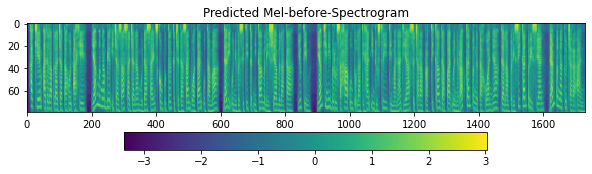

In [22]:
mel_outputs_ = np.reshape(o[1], [-1, 80])
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-before-Spectrogram')
im = ax1.imshow(np.rot90(mel_outputs_), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

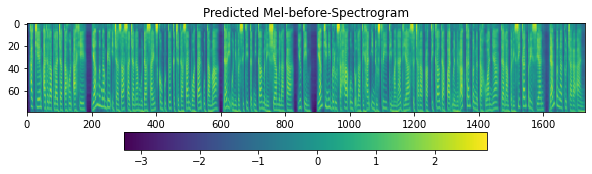

In [23]:
mel_outputs_ = np.reshape(o[0], [-1, 80])
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-before-Spectrogram')
im = ax1.imshow(np.rot90(mel_outputs_), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

In [24]:
universal = malaya_speech.vocoder.melgan()

In [25]:
y = universal(o[1][0])
y.shape

2022-06-13 14:33:59.015809: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 33554432 exceeds 10% of system memory.
2022-06-13 14:33:59.061345: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 33554432 exceeds 10% of system memory.
2022-06-13 14:33:59.105025: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 33554432 exceeds 10% of system memory.
2022-06-13 14:33:59.145955: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 33554432 exceeds 10% of system memory.
2022-06-13 14:33:59.174683: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 33554432 exceeds 10% of system memory.


(442624,)

In [26]:
import IPython.display as ipd
ipd.Audio(y, rate = 22050)

In [27]:
saver = tf.train.Saver()
saver.save(sess, 'lightspeech-yasmin-output/model.ckpt')

'lightspeech-yasmin-output/model.ckpt'

In [28]:
strings = ','.join(
    [
        n.name
        for n in tf.get_default_graph().as_graph_def().node
        if ('Variable' in n.op
        or 'gather' in n.op.lower()
        or 'Placeholder' in n.name
        or 'ratios' in n.name
        or 'post_mel_outputs' in n.name
        or 'decoder_output' in n.name
        or 'alignment_histories' in n.name)
        and 'adam' not in n.name
        and 'global_step' not in n.name
        and 'Assign' not in n.name
        and 'ReadVariableOp' not in n.name
        and 'Gather' not in n.name
        and 'IsVariableInitialized' not in n.name
    ]
)
strings.split(',')

['Placeholder',
 'Placeholder_1',
 'Placeholder_2',
 'Placeholder_3',
 'Placeholder_4',
 'Placeholder_5',
 'Placeholder_6',
 'Placeholder_7',
 'weight',
 'model/embeddings/position_embeddings/Placeholder',
 'model/decoder/position_embeddings/Placeholder',
 'speed_ratios',
 'f0_ratios',
 'energy_ratios',
 'decoder_output',
 'post_mel_outputs']

In [29]:
def freeze_graph(model_dir, output_node_names):

    if not tf.gfile.Exists(model_dir):
        raise AssertionError(
            "Export directory doesn't exists. Please specify an export "
            'directory: %s' % model_dir
        )

    checkpoint = tf.train.get_checkpoint_state(model_dir)
    input_checkpoint = checkpoint.model_checkpoint_path

    absolute_model_dir = '/'.join(input_checkpoint.split('/')[:-1])
    output_graph = absolute_model_dir + '/frozen_model.pb'
    clear_devices = True
    with tf.Session(graph = tf.Graph()) as sess:
        saver = tf.train.import_meta_graph(
            input_checkpoint + '.meta', clear_devices = clear_devices
        )
        saver.restore(sess, input_checkpoint)
        output_graph_def = tf.graph_util.convert_variables_to_constants(
            sess,
            tf.get_default_graph().as_graph_def(),
            output_node_names.split(','),
        )
        with tf.gfile.GFile(output_graph, 'wb') as f:
            f.write(output_graph_def.SerializeToString())
        print('%d ops in the final graph.' % len(output_graph_def.node))

In [30]:
freeze_graph('lightspeech-yasmin-output', strings)




INFO:tensorflow:Restoring parameters from lightspeech-yasmin-output/model.ckpt
INFO:tensorflow:Froze 123 variables.
INFO:tensorflow:Converted 123 variables to const ops.

1486 ops in the final graph.


In [31]:
def load_graph(frozen_graph_filename):
    with tf.gfile.GFile(frozen_graph_filename, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
                
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def)
        
    return graph

In [32]:
g = load_graph('lightspeech-yasmin-output/frozen_model.pb')

In [33]:
test_sess = tf.InteractiveSession(graph = g)

In [34]:
X = g.get_tensor_by_name('import/Placeholder:0')
speed_ratios = g.get_tensor_by_name('import/speed_ratios:0')
f0_ratios = g.get_tensor_by_name('import/f0_ratios:0')
energy_ratios = g.get_tensor_by_name('import/energy_ratios:0')


In [35]:
output_nodes = ['decoder_output', 'post_mel_outputs']
outputs = {n: g.get_tensor_by_name(f'import/{n}:0') for n in output_nodes}

In [36]:
%%time

o = test_sess.run(outputs, feed_dict = {X: [ids], 
                             speed_ratios: [1.0],
                             f0_ratios: [1.0], 
                             energy_ratios: [1.0]})

CPU times: user 640 ms, sys: 41.6 ms, total: 681 ms
Wall time: 142 ms


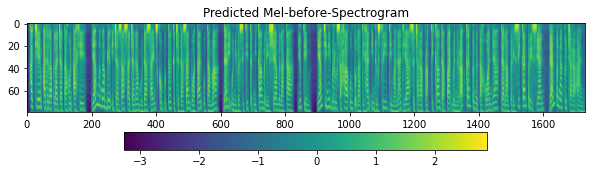

In [37]:
mel_outputs_ = np.reshape(o['decoder_output'], [-1, 80])
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-before-Spectrogram')
im = ax1.imshow(np.rot90(mel_outputs_), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

In [38]:
from tensorflow.tools.graph_transforms import TransformGraph

In [39]:
transforms = ['add_default_attributes',
             'remove_nodes(op=Identity, op=CheckNumerics)',
             'fold_batch_norms',
             'fold_old_batch_norms',
             'quantize_weights(fallback_min=-1024, fallback_max=1024)',
             'strip_unused_nodes',
             'sort_by_execution_order']

In [40]:
pb = 'lightspeech-yasmin-output/frozen_model.pb'

In [41]:
input_graph_def = tf.GraphDef()
with tf.gfile.FastGFile(pb, 'rb') as f:
    input_graph_def.ParseFromString(f.read())

transformed_graph_def = TransformGraph(input_graph_def, 
                                           ['Placeholder', 'speed_ratios', 'f0_ratios', 'energy_ratios'],
                                           output_nodes, transforms)
    
with tf.gfile.GFile(f'{pb}.quantized', 'wb') as f:
    f.write(transformed_graph_def.SerializeToString())

2022-06-13 14:34:31.952264: I tensorflow/tools/graph_transforms/transform_graph.cc:318] Applying add_default_attributes
2022-06-13 14:34:31.963837: I tensorflow/tools/graph_transforms/transform_graph.cc:318] Applying remove_nodes
2022-06-13 14:34:31.970216: I tensorflow/tools/graph_transforms/remove_nodes.cc:78] Skipping replacement for decoder_output
2022-06-13 14:34:31.970241: I tensorflow/tools/graph_transforms/remove_nodes.cc:78] Skipping replacement for post_mel_outputs
2022-06-13 14:34:31.976708: I tensorflow/tools/graph_transforms/remove_nodes.cc:78] Skipping replacement for decoder_output
2022-06-13 14:34:31.976736: I tensorflow/tools/graph_transforms/remove_nodes.cc:78] Skipping replacement for post_mel_outputs
2022-06-13 14:34:31.982383: I tensorflow/tools/graph_transforms/remove_nodes.cc:78] Skipping replacement for decoder_output
2022-06-13 14:34:31.982413: I tensorflow/tools/graph_transforms/remove_nodes.cc:78] Skipping replacement for post_mel_outputs
2022-06-13 14:34:31.

In [42]:
g = load_graph('lightspeech-yasmin-output/frozen_model.pb.quantized')

In [43]:
test_sess = tf.InteractiveSession(graph = g)
X = g.get_tensor_by_name(f'import/Placeholder:0')
speed_ratios = g.get_tensor_by_name('import/speed_ratios:0')
f0_ratios = g.get_tensor_by_name('import/f0_ratios:0')
energy_ratios = g.get_tensor_by_name('import/energy_ratios:0')
outputs = {n: g.get_tensor_by_name(f'import/{n}:0') for n in output_nodes}

In [44]:
%%time

o = test_sess.run(outputs, feed_dict = {X: [ids], 
                             speed_ratios: [1.0],
                             f0_ratios: [1.0], 
                             energy_ratios: [1.0]})

CPU times: user 662 ms, sys: 78.1 ms, total: 740 ms
Wall time: 192 ms


In [45]:
!cp lightspeech-yasmin/*.tfevents.* lightspeech-yasmin-output
!cp -r lightspeech-yasmin/eval lightspeech-yasmin-output
!tar -cvf lightspeech-yasmin-output.tar lightspeech-yasmin-output

cp: cannot stat 'lightspeech-yasmin/eval': No such file or directory
lightspeech-yasmin-output/
lightspeech-yasmin-output/checkpoint
lightspeech-yasmin-output/frozen_model.pb.quantized
lightspeech-yasmin-output/events.out.tfevents.1655050323.huseincomel-desktop
lightspeech-yasmin-output/model.ckpt.index
lightspeech-yasmin-output/model.ckpt.data-00000-of-00001
lightspeech-yasmin-output/model.ckpt.meta
lightspeech-yasmin-output/frozen_model.pb
lightspeech-yasmin-output/events.out.tfevents.1655050454.huseincomel-desktop


In [46]:
from malaya_boilerplate.huggingface import upload_dict

In [ ]:
files_mapping = {'lightspeech-yasmin-output.tar': 'lightspeech-yasmin-output.tar'}
upload_dict(model = 'pretrained-lightspeech', files_mapping = files_mapping)

409 Client Error: Conflict for url: https://huggingface.co/api/repos/create - You already created this model repo


In [ ]:
files_mapping = {'lightspeech-yasmin-output/frozen_model.pb': 'model.pb'}
upload_dict(model = 'text-to-speech-lightspeech-yasmin', files_mapping = files_mapping)

In [ ]:
files_mapping = {'lightspeech-yasmin-output/frozen_model.pb.quantized': 'model.pb'}
upload_dict(model = 'text-to-speech-lightspeech-yasmin-quantized', files_mapping = files_mapping)